<div class="alert alert-success">
    <b>EXERCISE 6</b>:
     <ul>
      <li> 
       1. Concatenate A,B,C,D and predict E for RHOB
       <li>
       2. Setup X and y matrices.
       <li>
       3. Normalize data and convert back to dataframe.
       <li>
       4. Perform RFE.
       <li>
       5. Perform hyperparameter tuning.
       <li>
       6. Predict VertE with RFE tuned model.
       <li>
       7. Plot VertE RHOB vs. prediction.
    
       
</div>

In [1]:
# Import toolboxes needed for workflow
import pandas as pd

from pandas import set_option
set_option('display.max_columns',100)
set_option('display.max_rows',1000)

import numpy as np

import operator

import os
import re

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
from sklearn.metrics.scorer import SCORERS
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split

from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import ColumnDataSource, ColorBar
from bokeh.palettes import Spectral6
from bokeh.transform import linear_cmap
from bokeh.plotting import figure
output_notebook()

/usr/local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Loading BokehJS ...

In [14]:
VertA = pd.read_excel('VertA_merge.xlsx')
VertB = pd.read_excel('VertB_merge.xlsx')
VertC = pd.read_excel('VertC_merge.xlsx')
VertD = pd.read_excel('VertD_merge.xlsx')
VertE = pd.read_excel('VertE_merge.xlsx')

In [15]:
# Correct porosity units NPRL:1 = NPOR = NPOR:1
# These values need to be made the same.
VertA['NPOR:1'] = VertA['NPOR:1']/100
VertB['NPRL:1'] = VertB['NPRL:1']/100
VertD['NPRL:1'] = VertD['NPRL:1']/100

In [16]:
# Merge A, B, C, D, and predict DT for E.
# And standardize column names.
# My RPM column for VertA is all zeros. 
# We might be able to use 'TOP_DRIVE_RPM' as a substitute.

VertA_subset = VertA[['DEPT','DT35','GMSG','ROP_-_FAST:1','BIT_WEIGHT','TOP_DRIVE_RPM','DEN','NPOR:1']]
VertB_subset = VertB[['DEPT','DT35','GMGC','ROP_-_FAST:1','BIT_WEIGHT','ROTARY_RPM','DEN','NPRL:1']]
VertC_subset = VertC[['DEPT','DTCO','GR','ROP_-_FAST:1','BIT_WEIGHT','ROTARY_RPM','RHOB','NPOR']]
VertD_subset = VertD[['DEPT','MCDT','GMGC','ROP_-_FAST:1','BIT_WEIGHT','ROTARY_RPM','DEN','NPRL:1']]
VertE_subset = VertE[['DEPT','DT','GRTO','ROP','WOB','RPM','RHOB','NPHI']]


VertA_subset = VertA_subset.rename(index=str,columns={"DT35":"DT","GMSG":"GR","ROP_-_FAST:1":"ROP","BIT_WEIGHT":"WOB","TOP_DRIVE_RPM":"RPM","DEN":"RHOB","NPOR:1":"NPHI"})
VertB_subset = VertB_subset.rename(index=str,columns={"DT35":"DT","GMGC":"GR","ROP_-_FAST:1":"ROP","BIT_WEIGHT":"WOB","ROTARY_RPM":"RPM","DEN":"RHOB","NPRL:1":"NPHI"})
VertC_subset = VertC_subset.rename(index=str,columns={"DTCO":"DT","GR":"GR","ROP_-_FAST:1":"ROP","BIT_WEIGHT":"WOB","ROTARY_RPM":"RPM","RHOB":"RHOB","NPOR":"NPHI"})
VertD_subset = VertD_subset.rename(index=str,columns={"MCDT":"DT","GMGC":"GR","ROP_-_FAST:1":"ROP","BIT_WEIGHT":"WOB","ROTARY_RPM":"RPM","DEN":"RHOB","NPRL:1":"NPHI"})
VertE_subset = VertE_subset.rename(index=str,columns={"GRTO":"GR"})


frames = [VertA_subset,VertB_subset,VertC_subset,VertD_subset]
mergeABCD = pd.concat(frames,ignore_index=True)

In [17]:
mergeABCD.shape

(21898, 8)

In [18]:
# Setup our X and y matrices
X_VertABCD = mergeABCD[['ROP','WOB','RPM','GR','DT','NPHI']]
y_VertABCD = mergeABCD['RHOB']

X_VertE = VertE_subset[['ROP','WOB','RPM','GR','DT','NPHI']]
y_VertE = VertE_subset['RHOB']

In [20]:
# SVR works much faster when data is normalized.

scaler = Normalizer().fit(X_VertABCD[['ROP','WOB','RPM','GR','DT','NPHI']])
normalized_mergeABCD_X = scaler.transform(X_VertABCD[['ROP','WOB','RPM','GR','DT','NPHI']])

scaler = Normalizer().fit(VertE_subset[['ROP','WOB','RPM','GR','RHOB','NPHI']])
normalized_VertE_subset_X = scaler.transform(VertE_subset[['ROP','WOB','RPM','GR','DT','NPHI']])

# Convert back to pandas dataframes
normalized_mergeABCD_X = pd.DataFrame(normalized_mergeABCD_X,columns=[['ROP','WOB','RPM','GR','DT','NPHI']])
normalized_VertE_subset_X = pd.DataFrame(normalized_VertE_subset_X,columns=[['ROP','WOB','RPM','GR','DT','NPHI']])

In [21]:
# Can we make this prediction better? Let's try a different regression method in sklearn.
# http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

from sklearn.svm import SVR
svr = SVR(kernel='linear',C=1232, gamma=10)

In [22]:
select = RFE(svr,n_features_to_select=4)

In [23]:
select.fit(normalized_mergeABCD_X, y_VertABCD)
normalized_mergeABCD_X_FS = select.transform(normalized_mergeABCD_X)
print(normalized_mergeABCD_X.shape)
print(normalized_mergeABCD_X_FS.shape)

(21898, 6)
(21898, 4)


In [24]:
mask = select.get_support()
mask

array([ True, False,  True, False,  True,  True])

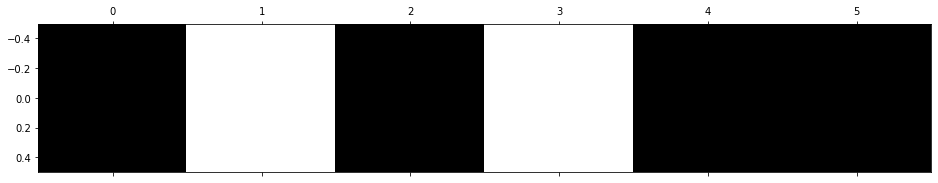

In [25]:
# Plot the mask. Black is True, White is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

In [26]:
normalized_mergeABCD_X.columns.tolist()

[('ROP',), ('WOB',), ('RPM',), ('GR',), ('DT',), ('NPHI',)]

In [27]:
normalized_mergeABCD_X_FS = pd.DataFrame(normalized_mergeABCD_X_FS,columns=[['ROP','RPM','DT','NPHI']])

In [28]:
# Perform cross-validation and hyperparameter tune.
cv = KFold(n_splits=5, random_state=42, shuffle=True)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1232], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=cv, verbose=1, return_train_score=True, n_jobs=-1)

grid.fit(normalized_mergeABCD_X_FS, y_VertABCD)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 20.5min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1232],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

In [29]:
print(grid.best_score_)

0.3419074383156566


In [30]:
print(grid.best_params_)

{'C': 1000, 'gamma': 10}


In [31]:
# Take the hyperparameter tuned model with RFE to predict DT for VertE.
hypertune_SVR = grid.predict(normalized_VertE_subset_X[['ROP','RPM','DT','NPHI']])

In [32]:
x = VertE['DEPT']
y = VertE['RHOB']
z = hypertune_SVR

p = figure(title='VertE Predicted RHOB using SVR', plot_width=800, plot_height=300)
r = p.line(x, y, color='green', line_width=0.5,legend_label='RHOB')
r1 = p.line(x, z, color='blue', line_width=0.5,legend_label='Pred. RHOB SVR')

p.xaxis.axis_label = 'Depth (ft)'
p.yaxis.axis_label = 'RHOB (???)'
p.legend.location = 'top_left'
show(p)

In [33]:
error = mean_absolute_error(y,z)
error

0.08066604149365225